# 2022-02-21 • Image, window, test

## Setup

In [1]:
# using Pkg; Pkg.resolve()

In [2]:
using Revise

In [3]:
using MyToolbox

In [4]:
using VoltageToMap

┌ Info: Precompiling VoltageToMap [b3b8fdc5-3c26-4000-a0c8-f17415fdf48e]
└ @ Base loading.jl:1423


## Params & sim

Short warm-up run. Get compilation out of the way.

In [11]:
p = SimParams(
    poisson_input = small_N__as_in_Python_2021,
    sim_duration  = 1*minutes
)
@time sim(p);

  0.139534 seconds (1.21 M allocations: 142.554 MiB, 10.45% gc time)


In [23]:
p = SimParams(
    poisson_input = realistic_input,
    sim_duration  = 10*seconds,
    Δg_multiplier = 0.1,
)
dump(p)

SimParams
  sim_duration: Float64 10.0
  Δt: Float64 0.0001
  num_timesteps: Int64 100000
  poisson_input: PoissonInputParams
    N_unconn: Int64 100
    N_exc: Int64 5200
    N_inh: Int64 1300
    N_conn: Int64 6500
    N: Int64 6600
    spike_rate: Distributions.LogNormal{Float64}
      μ: Float64 1.0862943611198905
      σ: Float64 0.7745966692414834
  synapses: SynapseParams
    g_t0: Float64 0.0
    τ_s: Float64 0.007
    E_exc: Float64 0.0
    E_inh: Float64 -0.065
    Δg_exc: Float64 4.0000000000000007e-10
    Δg_inh: Float64 1.6000000000000003e-9
  izh_neuron: IzhNeuronParams
    v_t0: Float64 -0.08
    u_t0: Float64 0.0
    C: Float64 1.0e-10
    k: Float64 7.0e-7
    vr: Float64 -0.06
    vt: Float64 -0.04
    a: Float64 30.0
    b: Float64 -2.0e-9
    v_peak: Float64 0.035
    v_reset: Float64 -0.05
    Δu: Float64 1.0e-10
  Δg_multiplier: Float64 0.1


In [24]:
t, v, input_spikes = @time sim(p);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


  2.442529 seconds (453.09 k allocations: 122.762 MiB, 1.69% gc time, 0.18% compilation time)


## Plot

In [25]:
import PyPlot

In [26]:
using Sciplotlib

In [27]:
""" tzoom = [200ms, 600ms] e.g. """
function plotsig(t, sig, tzoom = nothing, clip_on=false)
    isnothing(tzoom) && (tzoom = t[[1, end]])
    izoom = first(tzoom) .≤ t .≤ last(tzoom)
    plot(t[izoom], sig[izoom]; clip_on)
end;

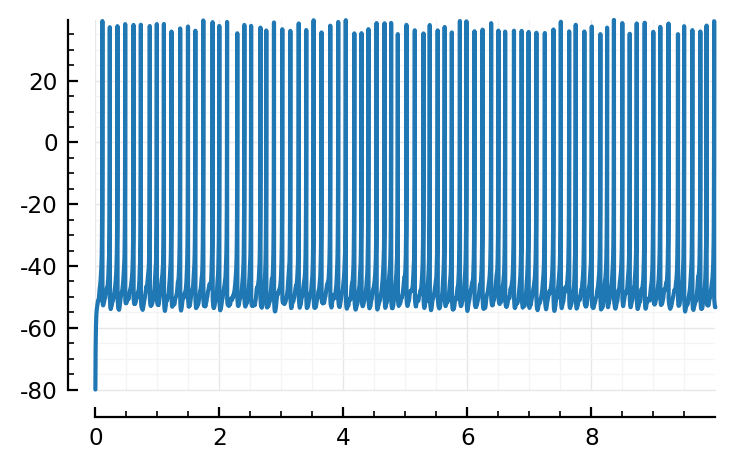

In [28]:
plotsig(t, v / mV);

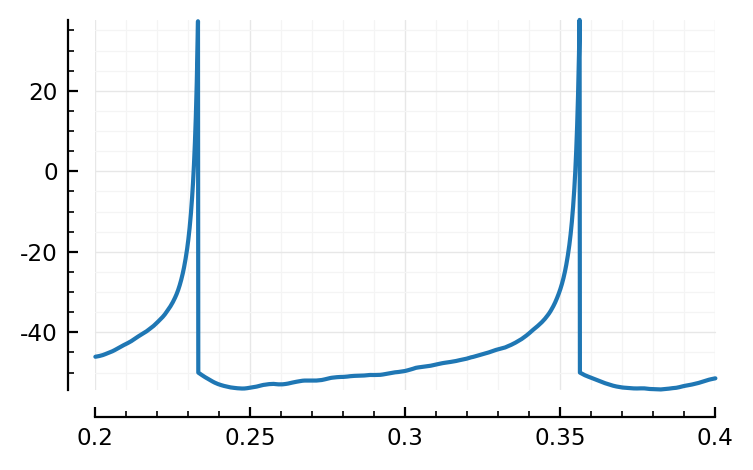

In [29]:
plotsig(t, v / mV, [200ms,400ms]);